In [1]:
# Importing packages
# --- Importing matplotlib, seaborn, etc.

import os
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import io
import pickle as pkl
import h5py
import xml.etree.ElementTree as ET

In [2]:
!pip install networkx==2.4
import networkx as nx

!pip install scikit-learn#0.22.2.post1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

!pip install xgboost==1.0.2
import xgboost as xgb

!pip install shap==0.35
import shap

!pip install python-igraph==0.8.2
import igraph as ig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2
    Uninstalling networkx-3.2:
      Successfully uninstalled networkx-3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
ERROR: Invalid requirement: 'scikit-learn#0.22.2.post1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.1
    Uninstalling xgboost-2.0.1:
      Successfully uninstalled xgboost-2.0.1


/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.3/273.3 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.35.0-cp310-cp310-linux_x86_64.whl size=390109 sha256=fa71ecdac29cdffaf8ac5cd1fe4f58d06093b1b641d80a6ed4315f82fa5cf279
  Stored in directory: /root/.cache/pip/wheels/74/26/82/d3e8a5f1ce5788e1839cfba17cef9d9c3afe312e9cb1e82e08
Successfully built shap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 39.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


ModuleNotFoundError: ignored

In [3]:
#These are the depths that the V-probe channels are located at
DEPTHS = [0.15,0.3,0.45,0.60,0.75,0.9,1.05,1.20,1.35,1.50,1.65,1.80,1.95,2.1,2.25,2.4]

#This converts time points to real time. There are 82 samples per waveform colleted at 30 kilosamples
SAMP_RATE_TO_TIME = 1/(82/30000)

#Setting of random seed across Python kernel and packages to ensure reproducibility
RAND_STATE=50
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

#UMAP Parameters
#The number of neighbors considered when constructing the high-d graph.
#Made more global-information preserving by increasing it from 15 to 20.
N_NEIGHBORS =  20#30 #36 #20

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.2 # 0.1

#Louvain Clustering Parameters
#increase resolution parameter to fewer clusters
RESOLUTION = 2.5#1.0 #2.0 # 1.5 #2.5

# BLUE COLOR
BlueCol = '\033[94m'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## Negative Spiking Waveforms
#from ismember import ismember
import numpy as np

print(BlueCol + 'Loading data')

rel_path = os.getcwd()

fullDataPath = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/normalizednegwaveforms6.mat');
filtfulldfPath = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/depth_neg_scaled6.mat');
ID_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/ID_neg6.mat');
full_data = scipy.io.loadmat(fullDataPath)['align_neg']
depth_data = scipy.io.loadmat(filtfulldfPath)['depth_neg_scaled']
ID_data = scipy.io.loadmat(ID_path)['ID_neg']



normwaveform_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/normwaveform.eps');
figure2_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters.eps');
clusters1_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters1.eps');
clusters2_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters2.eps');
clusters3_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters3.eps');
clusters4_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters4.eps');
clusters5_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters5.eps');
clusters6_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters6.eps');
clusters7_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters7.eps');
clusters8_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters8.eps');
clusters9_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/clusters9.eps');
figure7_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/laminar.eps');
figure8_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/laminar2.eps');
figure9_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/confusionmatrix.eps');
figure10_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/ECG.eps');
figure11_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/res_mod.eps');
figure12_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/TP_Dur.eps');
figure13_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/Amp.eps');
figure14_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/REP.eps');
figure15_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/3 2 2023/layercountsbycluster.eps');


cluster_data_final_path = os.path.join(rel_path,'drive/MyDrive/Chand Lab/Shude Data/Functional Data/cluster_data_final.csv');


df = pd.read_csv(r'drive/MyDrive/Chand Lab/Shude Data/Functional Data/cluster_data_final.csv')
print(df)

print(full_data.shape)
print(depth_data.shape)
print(ID_data.shape)


Loading data
     Cluster 2.5        Depth   ID  Session  Orientation Index  \
0              4  -995.623902    4        1           0.091415   
1              4  -970.000000    6        1           0.911915   
2              4  -697.800332   36        1           0.677103   
3              4  -650.000000   39        1           0.430064   
4              4  -650.000000   40        1           0.227424   
..           ...          ...  ...      ...                ...   
796            4 -1510.000000  666        5           0.246984   
797            4 -1963.960485  672        5           0.330732   
798            4 -1968.985952  673        5           0.671820   
799            1   196.074312  674        5           0.473463   
800            0 -1330.057592  676        5           0.307068   

     Orientation Cicular Variance  Direction Index  \
0                        0.976032         0.149807   
1                        0.301624         0.597626   
2                        0.56958

Plotting: 801 Waveforms


Text(0.5, 1.0, 'Normalized Waveforms')

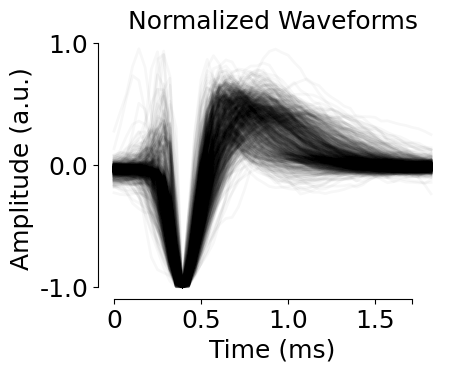

In [6]:
# This plots all the normalized single unit waveforms together. The total waveform length is 48 points at 30000 samples/s
# 14, 28, 42 are the 0.5 ms, 1.0 ms, and 1.5 ms

# Generate subplots
f, arr = plt.subplots(1,figsize=[4.5,3.4])

print(BlueCol + "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i].T, c = 'k', alpha = 0.03,linewidth=2.);

arr.tick_params(direction='out',colors='k', axis='both')

# Set various x and y axes and labels etc.
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)

arr.spines['left'].set_bounds(-1,1)
arr.spines['bottom'].set_bounds(0,48)

arr.set_xlabel('Time (ms)', fontsize=18);
arr.set_xticks([0,14,28,42,48])
arr.set_xticklabels(['0','0.5','1.0','1.5',''],fontsize=18)

arr.set_ylabel('Amplitude (a.u.)', fontsize=18)
arr.set_yticks([-1.0,0.0,1.0]);
arr.set_yticklabels([-1.0,0.0,1.0], fontsize=18);

arr.set_title('Normalized Waveforms', fontsize=18)

# Plot the data
#plt.tight_layout()
#plt.draw
#plt.savefig(normwaveform_path, bbox_inches='tight', format='eps', dpi=300)

In [ ]:
reducer = umap.UMAP(n_neighbors = N_NEIGHBORS, min_dist=MIN_DIST,
                    random_state=RAND_STATE)
mapper = reducer.fit(full_data)
embedding = reducer.transform(full_data)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(full_data)

NameError: ignored

In [ ]:
G = nx.from_scipy_sparse_matrix(mapper.graph_)
clustering = cylouvain.best_partition(G, resolution = RESOLUTION)
clustering_solution = list(clustering.values())
umap_df['color'] = clustering_solution

cluster_colors = [CUSTOM_PAL_SORT_3[i] for i in clustering_solution]
#cluster_colors = [blues[i] for i in clustering_solution]

In [ ]:
f,arr = plt.subplots(1,figsize=[7,4.5],tight_layout = {'pad': 0});
f.tight_layout()
arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),
            marker='o', c=cluster_colors, s=32, edgecolor='w',
            linewidth=0.5)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xticks([]);
arr.set_yticks([]);
arr.set_xlim(-10,20)
arr.set_ylim(-3,9)
arr.arrow(-8,-0.8,0,1.5, width=0.05, shape="full", ec="none", fc="black")
arr.arrow(-8,-0.8,1.2,0, width=0.05, shape="full", ec="none", fc="black")

arr.text(-8,-1.3,"UMAP 1", va="center")
arr.text(-8.7,-0.7,"UMAP 2",rotation=90, ha="left", va="bottom")
############

N_CLUST = len(set(clustering_solution))
#plt.savefig(figure2_path, bbox_inches='tight', format='eps', dpi = 300)
f.savefig(figure2_path,dpi = 300)

In [ ]:
print(cluster_data)

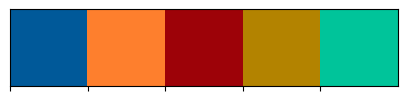

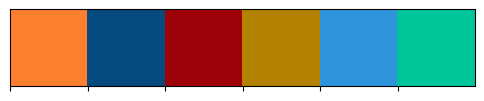

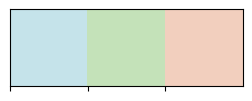

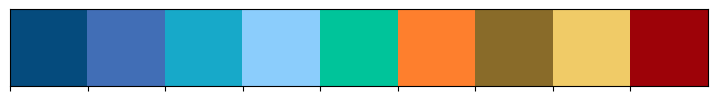

In [7]:
# all colors
CUSTOM_PAL_SORT_3 = ['#005999','#fe7f2d','#9d0208','#b38300','#00c49a','#7bdff2','#5e60ce','#efa6c9','#ced4da','#d62424','#12db41','#f0c905','#248cd6', '#3366ff','#0099cc']
# 420
#CUSTOM_PAL_SORT_3 = ['#00c49a','#fe7f2d','#005999','#9d0208']#,'#b38300','#7bdff2','#5e60ce','#efa6c9','#ced4da','#d62424','#12db41','#f0c905','#248cd6', '#3366ff','#0099cc']
# 5 clusters
#CUSTOM_PAL_SORT_3 = ['#00c49a','#fe7f2d','#005999','#9d0208','#b38300']#,'#7bdff2','#5e60ce','#efa6c9','#ced4da','#d62424','#12db41','#f0c905','#248cd6', '#3366ff','#0099cc']
nColors =  9

CUSTOM_PAL_SORT_3 = CUSTOM_PAL_SORT_3[0:nColors]

res2_5 = ['#005999','#fe7f2d','#9d0208','#b38300','#00c49a']

res2_0 = ['#fe7f2d','#054b7d','#9d0208','#b38300','#2e94db','#00c49a']

res1_5 = ['#054b7d','#fe7f2d','#9d0208','#b38300','#2e94db','#00c49a']

res1_0 = ['#054b7d','#416EB6','#fe7f2d','#9d0208','#f0cb67','#8bcdfc','#00c49a','#17A9C9','#896B29']

res1_0a = ['#054b7d','#416EB6','#17A9C9','#8bcdfc','#00c49a','#fe7f2d','#896B29','#f0cb67','#9d0208']
CUSTOM_PAL_SORT_3 = res1_0





GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

broadClasses = ['#C5E3EA','#C4E2B9','#F2CFBE']#,'#b38300'] #,'#e85d04','#dc2f02','#9d0208','#6a040f'] #ff66ff
Cold_colors = ['#00c49a','#005999']#, '#7bdff2']#'#00b4d8', '#0077b6', '#03045e']
#CUSTOM_PAL_SORT_3 = (Warm_colors, Cold_colors)

#CUSTOM_PAL_SORT_3 = join([Cold_colors],[Warm_colors])
blues = sns.color_palette("Blues")
CUSTOM_PAL_SORT_4 = blues[0:nColors]
# In RGB form
coherence_colors = [[0.609, 0.283,	0.724],
[0.259,	0.314, 0.635],
[0.251,	0.412, 0.698],
[0.176,	0.631, 0.859],
[0.369,	0.749, 0.549],
[0.898,	0.654, 0.169],
[0.898,	0.41, 0.165]]
sns.palplot(res2_5)
sns.palplot(res2_0)
sns.palplot(broadClasses)
sns.palplot(res1_0a)
#sns.palplot(CUSTOM_PAL_SORT_3)
#sns.palplot(CUSTOM_PAL_SORT_4)
#sns.palplot(blues)


In [8]:
df_s = df.loc[lambda df: df['Vis Responsive'] == 1, :]

df_s['broadClasses'] = 5
df_s.loc[lambda df: df['cluster 1.0'] == 0,'broadClasses'] = 10
df_s.loc[lambda df: df['cluster 1.0'] == 1,'broadClasses'] = 10
df_s.loc[lambda df: df['cluster 1.0'] == 5,'broadClasses'] = 10
df_s.loc[lambda df: df['cluster 1.0'] == 7,'broadClasses'] = 10
df_s.loc[lambda df: df['cluster 1.0'] == 6,'broadClasses'] = 20
df_s.loc[lambda df: df['cluster 1.0'] == 2,'broadClasses'] = 30
df_s.loc[lambda df: df['cluster 1.0'] == 3,'broadClasses'] = 30
df_s.loc[lambda df: df['cluster 1.0'] == 4,'broadClasses'] = 30
df_s.loc[lambda df: df['cluster 1.0'] == 8,'broadClasses'] = 30
#df_s.assign(broadClasses=lambda df_s: df_s['cluster 1.0'] * 2)
print(df_s)

     Cluster 2.5       Depth   ID  Session  Orientation Index  \
1              4 -970.000000    6        1           0.911915   
2              4 -697.800332   36        1           0.677103   
6              2 -552.139565   46        1           0.386120   
7              4 -490.000000   52        1           0.857968   
8              4 -490.000000   53        1           0.244722   
..           ...         ...  ...      ...                ...   
789            3  -33.624086  635        5           0.352663   
792            1  -11.143926  652        5           0.014673   
793            0  394.830087  657        5           0.993030   
794            4 -134.210501  661        5           0.245372   
799            1  196.074312  674        5           0.473463   

     Orientation Cicular Variance  Direction Index  \
1                        0.301624         0.597626   
2                        0.569588         0.086586   
6                        0.818944         0.214000   
7  


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


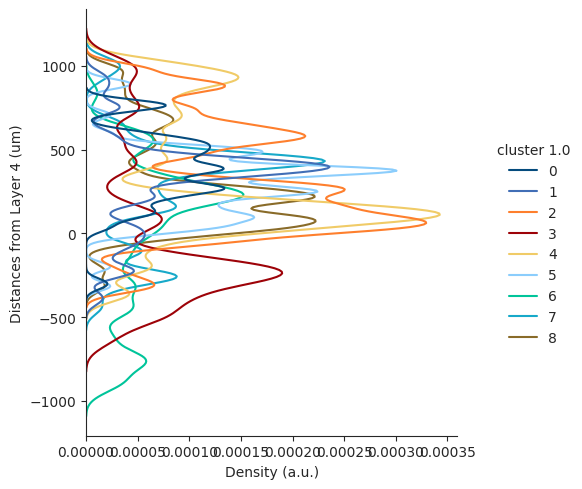

In [9]:
CustomPalette = sns.color_palette(res1_0a)
customPalette = sns.color_palette(CUSTOM_PAL_SORT_3)
narrowPalette = sns.color_palette(CUSTOM_PAL_SORT_3)#(Cold_colors)
broadPalette = sns.color_palette(broadClasses)
sns.set_style("ticks")
HueOrder = [0,1,7,5,6,2,8,4,3]

f = sns.displot(y='depth_scaled', hue='cluster 1.0', data=df_s, kind='kde', bw_adjust = 0.3, palette=customPalette)

f.set_axis_labels('Density (a.u.)', 'Distances from Layer 4 (um)')

(607, 23)


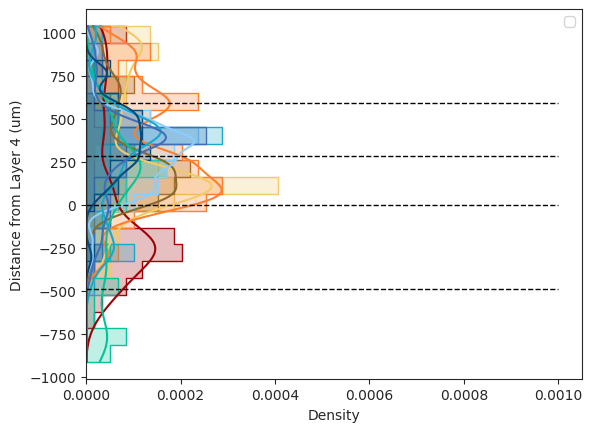

In [18]:
####### This is laminar 1

#sns.histplot(y='Depth',data=s,bins=18,element='step',kde = True,kde_kws={},hue='Cluster',palette=customPalette)
sns.histplot(y='depth_scaled',data=df_s,bins=20,element='step',kde = True,kde_kws={'bw_adjust':0.55},hue='cluster 1.0',palette=CustomPalette,hue_order=HueOrder,stat = 'density')

plt.plot([0, 0.001],[588.8, 588.8],'--',color = 'black',lw=1)
plt.plot([0, 0.001],[285.4, 285.4],'--',color = 'black',lw=1)
plt.plot([0, 0.001],[0,0],'--',color = 'black',lw=1)
plt.plot([0, 0.001],[-488, -488],'--',color = 'black',lw=1)
plt.ylabel('Distance from Layer 4 (um)')
plt.legend(loc='upper right')

plt.show
#plt.savefig(figure7_path, bbox_inches='tight', format='pdf')
plt.savefig(figure7_path, dpi=300)
print(df_s.shape)

<function matplotlib.pyplot.show(close=None, block=None)>

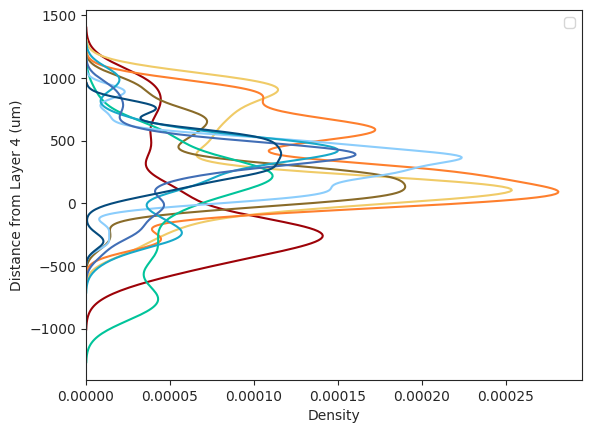

In [ ]:
sns.kdeplot(data=df_s,y='depth_scaled',hue='cluster 1.0',palette=CustomPalette,hue_order=HueOrder,bw_adjust=.6)
#,hue='cluster 1.0',palette=CustomPalette,hue_order=HueOrder
#plt.plot([0, 1],[588.8, 588.8],'--',color = 'black',lw=1)
#plt.plot([0, 1],[285.4, 285.4],'--',color = 'black',lw=1)
#plt.plot([0, 1],[0,0],'--',color = 'black',lw=1)
#plt.plot([0, 1],[-488, -488],'--',color = 'black',lw=1)
plt.ylabel('Distance from Layer 4 (um)')
plt.legend(loc='upper right')

plt.show

(607,)


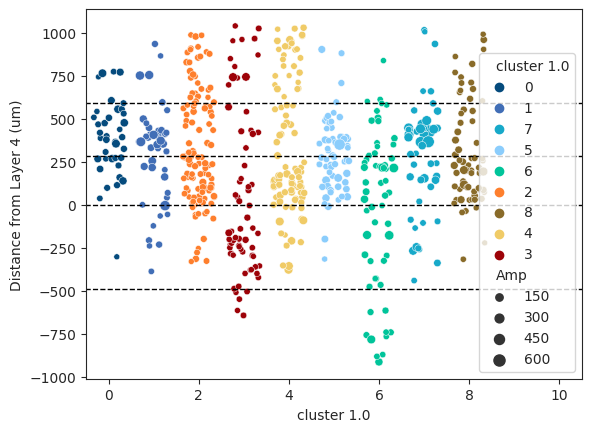

In [ ]:
########### JK this is laminar 2


#sns.stripplot(x='Cluster', y='Depth', data=S,palette=CustomPalette,jitter=0.4)
ax = sns.scatterplot(x='cluster 1.0', y='depth_scaled',hue='cluster 1.0',data=df_s,hue_order=HueOrder,palette=CustomPalette,size='Amp')
for dots in ax.collections:
    xy = dots.get_offsets()
    xy += np.c_[np.random.uniform(-.35, .35, len(xy)), np.zeros(len(xy))]
    dots.set_offsets(xy)
ax.set_xlim(-.5, len(ax.get_xticks()) - .5) # add some more space


plt.plot([-1, 12],[588.8, 588.8],'--',color = 'black',lw=1)
plt.plot([-1, 12],[285.4, 285.4],'--',color = 'black',lw=1)
plt.plot([-1, 12],[0,0],'--',color = 'black',lw=1)
plt.plot([-1, 12],[-488, -488],'--',color = 'black',lw=1)
plt.ylabel('Distance from Layer 4 (um)')

plt.savefig(figure8_path, dpi=300)

Passing `palette` without assigning `hue` is deprecated.


Text(0, 0.5, 'Distance from Layer 4 (um)')

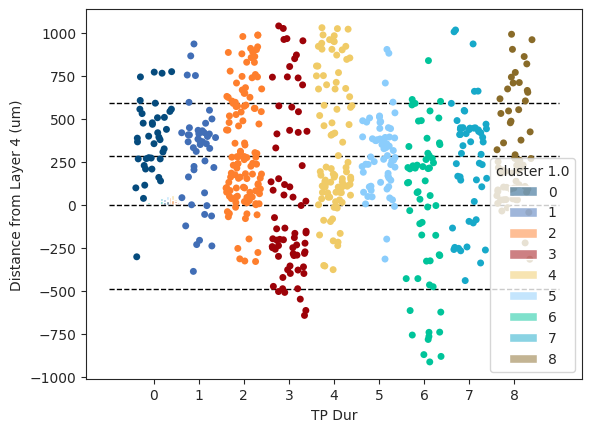

In [ ]:
sns.histplot(x='TP Dur',data=s,bins=18,hue='cluster 1.0',palette=customPalette)
sns.stripplot(x='cluster 1.0', y='depth_scaled',data=df_s, palette=customPalette,jitter=0.4)

plt.plot([-1, 9],[588.8, 588.8],'--',color = 'black',lw=1)
plt.plot([-1, 9],[285.4, 285.4],'--',color = 'black',lw=1)
plt.plot([-1, 9],[0,0],'--',color = 'black',lw=1)
plt.plot([-1, 9],[-488, -488],'--',color = 'black',lw=1)
plt.ylabel('Distance from Layer 4 (um)')

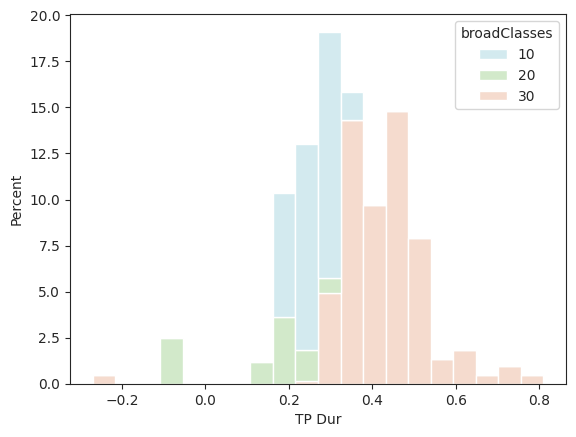

In [ ]:
sns.histplot(x='TP Dur',data=df_s,bins=20,multiple="stack",hue='broadClasses',palette=broadPalette,stat='percent')
#plt.savefig(figure12_path, dpi=300)

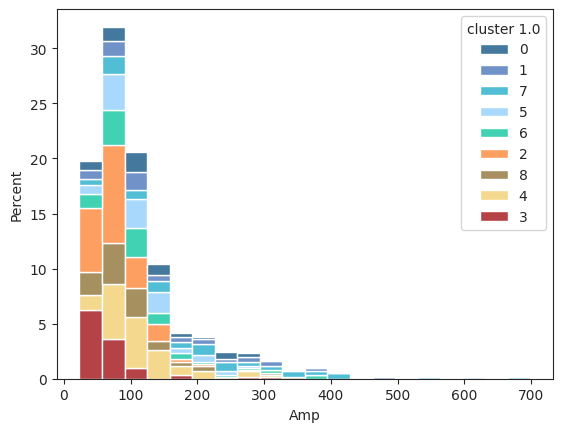

In [ ]:
sns.histplot(x='Amp',data=df_s,bins=20,multiple="stack",hue='cluster 1.0',palette=CustomPalette,hue_order=HueOrder,stat='percent')
#plt.savefig(figure13_path, dpi=300)

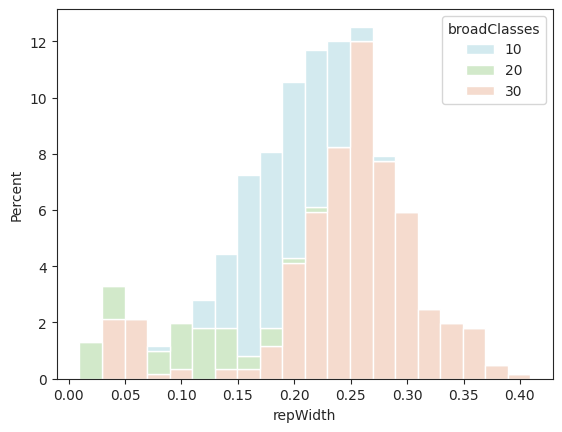

In [ ]:
sns.histplot(x='repWidth',data=df_s,bins=20,multiple="stack",hue='broadClasses',palette=broadPalette,stat='percent')
#plt.savefig(figure14_path, dpi=300)

<Axes: xlabel='Count', ylabel='depth_bins'>

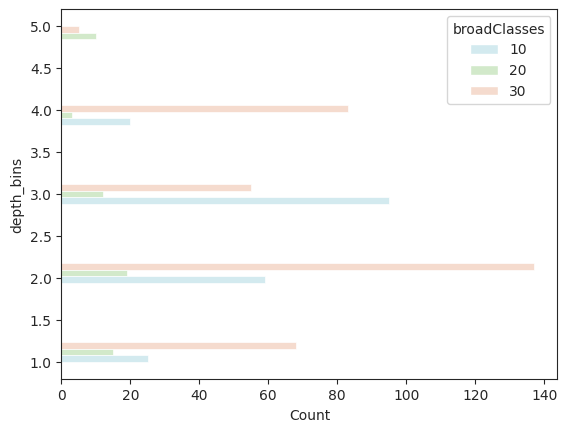

In [ ]:
sns.histplot(y='depth_bins',data=df_s,multiple="dodge",hue='broadClasses',palette=broadPalette,stat='count')

#plt.savefig(figure15_path, dpi=300)

Confusion Matrix

In [ ]:
testSize = 0.3;

#UMAP_X = np.stack(full_data.to_numpy().tolist(), axis=0)
UMAP_X = full_data
UMAP_y = df['cluster 1.0'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)

In [ ]:
numCV = 5

UMAP_model = xgb.XGBClassifier()
UMAP_param_dist = {"max_depth": [4],
              "min_child_weight" : [2.5],
              "n_estimators": [100],
              "learning_rate": [0.3],
              "seed": [RAND_STATE]}
UMAP_grid_search = GridSearchCV(UMAP_model, param_grid=UMAP_param_dist,
                           cv = numCV,
                           verbose=10, n_jobs=-1)
UMAP_grid_search.fit(UMAP_X_train, UMAP_y_train)

confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test),labels=HueOrder)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


array([[12,  1,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 17,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 19,  0,  1,  0,  0,  0,  1],
       [ 0,  0,  0, 20,  0,  0,  2,  0,  0],
       [ 0,  0,  2,  0, 45,  0,  0,  2,  0],
       [ 0,  0,  0,  3,  0, 30,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 23,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 26,  2],
       [ 0,  0,  0,  0,  0,  1,  0,  4, 20]])

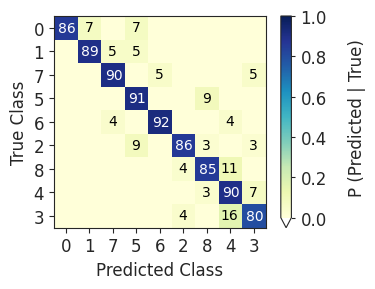

In [ ]:
confusion_mat_counts = confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test),labels = HueOrder)

conf_mat_row_list = []
N_CLUST = 9

for row in confusion_mat_counts:
    row_sum = np.sum(row)

    row_percent = []

    for val in row:
        row_percent.append(val/row_sum)

    conf_mat_row_list.append(row_percent)

conf_mat = np.array(conf_mat_row_list)

colormap = mpl.cm.YlGnBu
colormap.set_under('w')

eps = np.spacing(0.0)
f, arr = plt.subplots(1,figsize=[4,3])
mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
color_bar = f.colorbar(mappable, ax=arr, extend='min')
color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15)
color_bar.ax.tick_params(size=3,labelsize=12)

#Specify label behavior of the main diagonal
for i in HueOrder:
    if int(conf_mat[i,i]*100) == 100:
        arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white')
    else:
        arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white')

#Specify label behavior of the off-diagonals
for i in HueOrder:
    for j in HueOrder:
        if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
            arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k')
        elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.5 and conf_mat[i,j] != 0:
            arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k')

arr.set_xticks(range(0,N_CLUST))
arr.set_xticklabels(HueOrder,fontsize=12);
arr.set_yticks(range(0,N_CLUST))
arr.set_yticklabels(HueOrder,fontsize=12);
arr.set_xlabel('Predicted Class',fontsize=12);
arr.set_ylabel('True Class',fontsize=12);
plt.tight_layout()
#plt.savefig(figure9_path, bbox_inches='tight', format='pdf')
plt.savefig(figure9_path, dpi=300)
#print(row_percent)

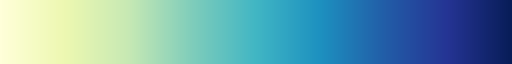

In [ ]:
colormap
